**Import dependencies**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

**Download dataset**

In [2]:
dataset_url = "http://download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file("flower_photos", origin=dataset_url, cache_dir='.', untar=True)

228827136/228813984 [==============================] - 1s 0us/step


**Or upload pre-downloaded dataset**

In [3]:
# # note that this code was executed in google colab and the dataset to be used was downloaded 
# # and saved in a folder synced with gdrive
# from google.colab import drive
# drive.mount('/content/drive')

# data_dir = "drive/Othercomputers/My MacBook Air/DeepLearningCNN/datasets/flower_photos/"

**Conversion and work with path objects**

In [4]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('datasets/flower_photos')

**Test pathlib use and display image**

datasets/flower_photos/roses/14172324538_2147808483_n.jpg


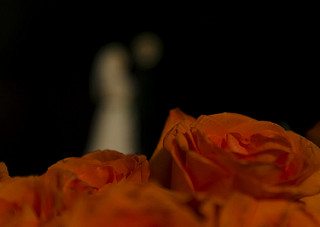

In [5]:
roses = list(data_dir.glob('roses/*'))
print(str(roses[0]))
PIL.Image.open(roses[0])

**Create labels and group images of the same label together with dictionary**

In [6]:
flowers = {
    'roses': list(data_dir.glob('roses/*')),
    'daisy': list(data_dir.glob('daisy/*')),
    'dandelion': list(data_dir.glob('dandelion/*')),
    'tulips': list(data_dir.glob('tulips/*')),
    'sunflowers': list(data_dir.glob('sunflowers/*'))
}

In [7]:
flowers_labels = {
    'roses': 0,
    'daisy': 1,
    'dandelion': 2,
    'tulips': 3,
    'sunflowers': 4

}

**Resize every image and store in lists**

In [8]:
X, y = [], []
for flower_name, images in flowers.items():
  for image in images:
    img = cv2.imread(str(image))
    resized_img = cv2.resize(img, (180,180))
    X.append(resized_img)
    y.append(flowers_labels[flower_name])



**Convert to numpy for efficiency**

In [9]:
X = np.array(X)
y = np.array(y)

**Obtain Train and Test sets**

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

**Rescale RGB values**

In [11]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

**Set-up model and train**

In [12]:
cnn = Sequential([
                  layers.Conv2D(16, 3, padding='same', activation = 'relu'),
                  layers.MaxPooling2D(),
                  layers.Conv2D(32, 3, padding='same', activation = 'relu'),
                  layers.MaxPooling2D(),
                  layers.Conv2D(64, 3, padding='same', activation = 'relu'),
                  layers.MaxPooling2D(),
                  layers.Flatten(),
                  layers.Dense(128, activation='relu'),
                  layers.Dense(5, activation='softmax')
])

cnn.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cnn.fit(X_train_scaled, y_train, epochs = 30)

Epoch 1/30
86/86 [==============================] - 13s 22ms/step - loss: 1.2998 - accuracy: 0.4629
Epoch 2/30
86/86 [==============================] - 2s 22ms/step - loss: 0.9881 - accuracy: 0.6163
Epoch 3/30
86/86 [==============================] - 2s 22ms/step - loss: 0.8069 - accuracy: 0.6919
Epoch 4/30
86/86 [==============================] - 2s 22ms/step - loss: 0.6066 - accuracy: 0.7696
Epoch 5/30
86/86 [==============================] - 2s 22ms/step - loss: 0.3812 - accuracy: 0.8757
Epoch 6/30
86/86 [==============================] - 2s 22ms/step - loss: 0.2125 - accuracy: 0.9284
Epoch 7/30
86/86 [==============================] - 2s 23ms/step - loss: 0.1278 - accuracy: 0.9600
Epoch 8/30
86/86 [==============================] - 2s 22ms/step - loss: 0.0946 - accuracy: 0.9720
Epoch 9/30
86/86 [==============================] - 2s 22ms/step - loss: 0.0363 - accuracy: 0.9906
Epoch 10/30
86/86 [==============================] - 2s 22ms/step - loss: 0.0225 - accuracy: 0.9945
Epoch 11

**Evalute model**

In [13]:
cnn.evaluate(X_test_scaled, y_test)

29/29 [==============================] - 1s 19ms/step - loss: 2.3829 - accuracy: 0.6721


[2.3829119205474854, 0.672113299369812]

**Augment datasets**

In [14]:
data_augmentation = keras.Sequential([
                                      layers.experimental.preprocessing.RandomFlip("horizontal",
                                                                                   input_shape=(180,
                                                                                                180,
                                                                                                3)),
                                      layers.experimental.preprocessing.RandomZoom(0.1),
                                      layers.experimental.preprocessing.RandomContrast(0.2),
                                      layers.experimental.preprocessing.RandomRotation(0.1)
                                      
])

**View a sample of an augmented data**

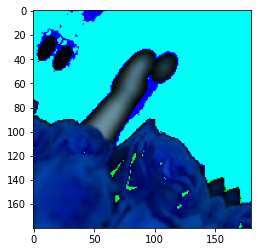

In [15]:
plt.imshow(data_augmentation(X)[0].numpy().astype('uint8'))

**Apply data augmentation to similarly set-up model, add drop-out layer**

In [16]:
cnn = Sequential([
                  data_augmentation,
                  layers.Conv2D(16, 3, padding='same', activation = 'relu'),
                  layers.MaxPooling2D(),
                  layers.Conv2D(32, 3, padding='same', activation = 'relu'),
                  layers.MaxPooling2D(),
                  layers.Conv2D(64, 3, padding='same', activation = 'relu'),
                  layers.MaxPooling2D(),
                  layers.Dropout(0.2),
                  layers.Flatten(),
                  layers.Dense(128, activation='relu'),
                  layers.Dense(5, activation='softmax')
])

cnn.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cnn.fit(X_train_scaled, y_train, epochs = 30)

Epoch 1/30
86/86 [==============================] - 3s 27ms/step - loss: 1.3327 - accuracy: 0.4172
Epoch 2/30
86/86 [==============================] - 2s 26ms/step - loss: 1.0812 - accuracy: 0.5676
Epoch 3/30
86/86 [==============================] - 2s 26ms/step - loss: 0.9782 - accuracy: 0.6272
Epoch 4/30
86/86 [==============================] - 2s 26ms/step - loss: 0.9087 - accuracy: 0.6472
Epoch 5/30
86/86 [==============================] - 2s 26ms/step - loss: 0.8659 - accuracy: 0.6523
Epoch 6/30
86/86 [==============================] - 2s 26ms/step - loss: 0.8260 - accuracy: 0.6824
Epoch 7/30
86/86 [==============================] - 2s 26ms/step - loss: 0.8079 - accuracy: 0.6853
Epoch 8/30
86/86 [==============================] - 2s 26ms/step - loss: 0.7609 - accuracy: 0.7078
Epoch 9/30
86/86 [==============================] - 2s 26ms/step - loss: 0.7059 - accuracy: 0.7347
Epoch 10/30
86/86 [==============================] - 2s 25ms/step - loss: 0.6734 - accuracy: 0.7376
Epoch 11/

**Observe improved results**

In [17]:
cnn.evaluate(X_test_scaled, y_test) 

29/29 [==============================] - 1s 15ms/step - loss: 1.0228 - accuracy: 0.7516


[1.0227952003479004, 0.7516340017318726]